# Growing Neural Cellular Automata

This notebook contains code to reproduce experiments and figures for the ["Growing Neural Cellular Automata"](http://distill.pub/2020/growing-ca) article.

Copyright 2020 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

---
# 生長式神經細胞自動機（Growing Neural Cellular Automata）

本 Notebook 包含用於重現 ["Growing Neural Cellular Automata"](http://distill.pub/2020/growing-ca) 文章中實驗與圖表的程式碼。

版權所有 © 2020 Google LLC

本程式碼依據 Apache 2.0 授權條款發布（以下簡稱「授權條款」）；
除非依據授權條款，否則不得使用本檔案。
你可以在以下網址取得授權條款全文：

    https://www.apache.org/licenses/LICENSE-2.0

除非適用法律另有要求，或書面同意，本程式碼依據「原樣提供」（AS IS），
不附帶任何明示或默示的保證，包括但不限於對適售性、特定用途適用性與非侵權性的保證。


In [ ]:
# 1. 標準庫
import sys
import os
import io
import json
import glob

# 2. 第三方套件
import numpy as np
import matplotlib.pylab as pl
import tensorflow as tf
import tqdm
from IPython.display import clear_output, display, HTML

# 3. 影片相關

import cv2

# 4. 設定 project 路徑（依你本機路徑調整）
project_root = "C:/Users/GAI/Desktop/Scott/NCA_Research"
if project_root not in sys.path:
    sys.path.append(project_root)

# 5. IPython 魔法指令（Jupyter專用）
%reload_ext autoreload
%autoreload 2

# 6. 專案內部 utils 函式庫導入

# 6.1 影像儲存與編碼工具
from core_utils.utils_io import (
    np2pil,      # numpy → PIL Image
    imwrite,     # 儲存圖像為檔案
    imencode,    # 編碼圖像為 byte stream
    im2url,      # 圖像轉 base64 URL（HTML 顯示用）
    load_emoji   # 載入 emoji 圖像
)

# 6.2 影像處理與顯示工具
from core_utils.utils_image import (
    imshow,      # 在 notebook 顯示圖像
    tile2d,      # 多圖拼接
    zoom         # 放大圖像
)

# 6.3 影片輸出工具
from core_utils.utils_video import (
    save_video,  # 批次輸出影片
    VideoWriter  # 逐幀寫入影片（支援 context manager）
)

# 6.4 TensorFlow 相關自訂操作（轉換通道）
from core_utils.ops_tensor import (
    to_rgb,
    to_rgba,
    to_alpha
)


from core_utils.viz_train import (
    viz_pool,
    viz_batch,
    viz_loss
)

clear_output()


# Global Params

In [43]:
#@title Cellular Automata Parameters
CHANNEL_N = 16        # Number of CA state channels
TARGET_PADDING = 16   # Number of pixels used to pad the target image border
TARGET_SIZE = 40
BATCH_SIZE = 8
POOL_SIZE = 1024
CELL_FIRE_RATE = 0.5

TARGET_EMOJI = "🦎" #@param {type:"string"}

EXPERIMENT_TYPE = "Regenerating" #@param ["Growing", "Persistent", "Regenerating"]
EXPERIMENT_MAP = {"Growing":0, "Persistent":1, "Regenerating":2}
EXPERIMENT_N = EXPERIMENT_MAP[EXPERIMENT_TYPE]

USE_PATTERN_POOL = [0, 1, 1][EXPERIMENT_N]
DAMAGE_N = [0, 0, 3][EXPERIMENT_N]  # Number of patterns to damage in a batch

In [44]:
from keras.layers import Conv2D

def get_living_mask(x):
  alpha = x[:, :, :, 3:4]
  return tf.nn.max_pool2d(alpha, 3, [1, 1, 1, 1], 'SAME') > 0.1

def make_seed(size, n=1):
  x = np.zeros([n, size, size, CHANNEL_N], np.float32)
  x[:, size//2, size//2, 3:] = 1.0
  return x

class CAModel(tf.keras.Model):

  def __init__(self, channel_n=CHANNEL_N, fire_rate=CELL_FIRE_RATE):
    super().__init__()
    self.channel_n = channel_n
    self.fire_rate = fire_rate

    self.dmodel = tf.keras.Sequential([
          Conv2D(128, 1, activation=tf.nn.relu),
          Conv2D(self.channel_n, 1, activation=None,
              kernel_initializer=tf.zeros_initializer),
    ])

    self(tf.zeros([1, 3, 3, channel_n]))  # dummy call to build the model

  @tf.function
  def perceive(self, x, angle=0.0):
    identify = np.float32([0, 1, 0])
    identify = np.outer(identify, identify)
    dx = np.outer([1, 2, 1], [-1, 0, 1]) / 8.0  # Sobel filter
    dy = dx.T
    c, s = tf.cos(angle), tf.sin(angle)
    kernel = tf.stack([identify, c*dx-s*dy, s*dx+c*dy], -1)[:, :, None, :]
    kernel = tf.repeat(kernel, self.channel_n, 2)
    y = tf.nn.depthwise_conv2d(x, kernel, [1, 1, 1, 1], 'SAME')
    return y

  @tf.function
  def call(self, x, fire_rate=None, angle=0.0, step_size=1.0):
    pre_life_mask = get_living_mask(x)

    y = self.perceive(x, angle)
    dx = self.dmodel(y)*step_size
    if fire_rate is None:
      fire_rate = self.fire_rate
    update_mask = tf.random.uniform(tf.shape(x[:, :, :, :1])) <= fire_rate
    x += dx * tf.cast(update_mask, tf.float32)

    post_life_mask = get_living_mask(x)
    life_mask = pre_life_mask & post_life_mask
    return x * tf.cast(life_mask, tf.float32)


CAModel().dmodel.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (1, 3, 3, 128)            6272      
                                                                 
 conv2d_19 (Conv2D)          (1, 3, 3, 16)             2064      
                                                                 
Total params: 8,336
Trainable params: 8,336
Non-trainable params: 0
_________________________________________________________________


# Training

In [ ]:
from E1_basicGNCA.utils.SamplePool import SamplePool


@tf.function
def make_circle_masks(n, h, w):
  x = tf.linspace(-1.0, 1.0, w)[None, None, :]
  y = tf.linspace(-1.0, 1.0, h)[None, :, None]
  center = tf.random.uniform([2, n, 1, 1], -0.5, 0.5)
  r = tf.random.uniform([n, 1, 1], 0.1, 0.4)
  x, y = (x-center[0])/r, (y-center[1])/r
  mask = tf.cast(x*x+y*y < 1.0, tf.float32)
  return mask


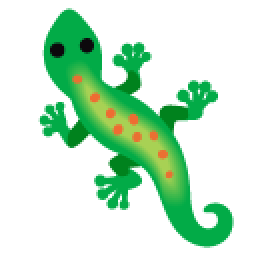

In [ ]:
target_img = load_emoji(TARGET_EMOJI)
imshow(zoom(to_rgb(target_img), 2), fmt='png')

In [ ]:
#@title Initialize Training { vertical-output: true}

p = TARGET_PADDING
pad_target = tf.pad(target_img, [(p, p), (p, p), (0, 0)])
h, w = pad_target.shape[:2]
seed = np.zeros([h, w, CHANNEL_N], np.float32)
seed[h//2, w//2, 3:] = 1.0

def loss_f(x):
  return tf.reduce_mean(tf.square(to_rgba(x)-pad_target), [-2, -3, -1])

ca = CAModel()

loss_log = []

lr = 2e-3
lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [2000], [lr, lr*0.1])
trainer = tf.keras.optimizers.Adam(lr_sched)

loss0 = loss_f(seed).numpy()
pool = SamplePool(x=np.repeat(seed[None, ...], POOL_SIZE, 0))

!mkdir -p train_log && rm -f train_log/*

�l�ؿ����ɮ� -p �w�g�s�b�C
�B�z�ɵo�Ϳ��~: -p�C
�l�ؿ����ɮ� train_log �w�g�s�b�C
�B�z�ɵo�Ϳ��~: train_log�C


batch (before/after):


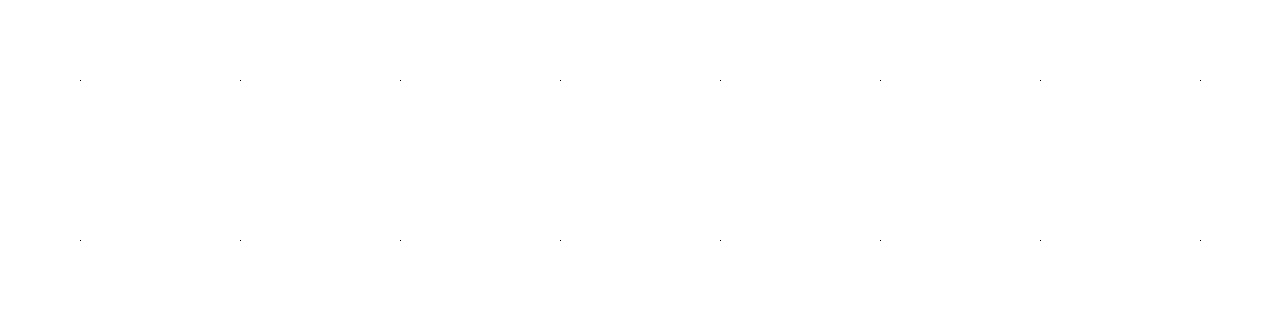

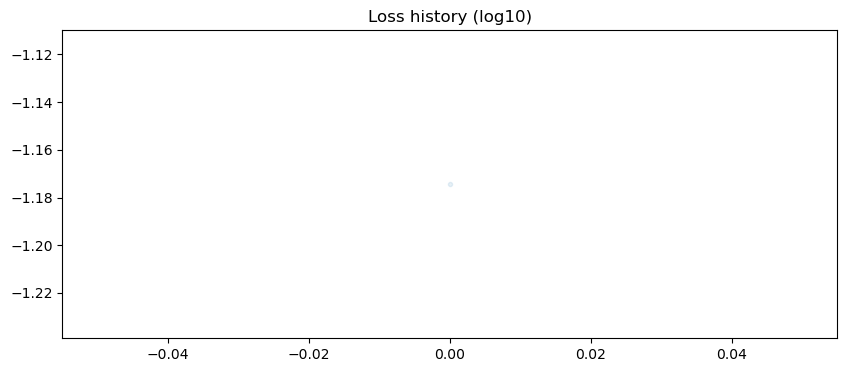

 step: 1, log10(loss): -1.174

ResourceExhaustedError: Graph execution error:

Detected at node 'sequential_8/conv2d_16/Conv2D' defined at (most recent call last):
    File "c:\Users\GAI\anaconda3\envs\NCA_tf_gpu\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\GAI\anaconda3\envs\NCA_tf_gpu\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\GAI\anaconda3\envs\NCA_tf_gpu\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\GAI\anaconda3\envs\NCA_tf_gpu\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\GAI\anaconda3\envs\NCA_tf_gpu\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\GAI\anaconda3\envs\NCA_tf_gpu\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\GAI\anaconda3\envs\NCA_tf_gpu\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\GAI\anaconda3\envs\NCA_tf_gpu\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\GAI\anaconda3\envs\NCA_tf_gpu\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\GAI\anaconda3\envs\NCA_tf_gpu\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\GAI\anaconda3\envs\NCA_tf_gpu\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\GAI\anaconda3\envs\NCA_tf_gpu\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\GAI\anaconda3\envs\NCA_tf_gpu\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\GAI\anaconda3\envs\NCA_tf_gpu\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\GAI\anaconda3\envs\NCA_tf_gpu\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "c:\Users\GAI\anaconda3\envs\NCA_tf_gpu\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\GAI\anaconda3\envs\NCA_tf_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "c:\Users\GAI\anaconda3\envs\NCA_tf_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "c:\Users\GAI\anaconda3\envs\NCA_tf_gpu\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\GAI\anaconda3\envs\NCA_tf_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\GAI\anaconda3\envs\NCA_tf_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\GAI\anaconda3\envs\NCA_tf_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\GAI\AppData\Local\Temp\ipykernel_12444\31304793.py", line 28, in <module>
      x, loss = train_step(x0)
    File "C:\Users\GAI\AppData\Local\Temp\ipykernel_12444\849231024.py", line 7, in train_step
      for i in tf.range(iter_n):
    File "C:\Users\GAI\AppData\Local\Temp\ipykernel_12444\849231024.py", line 8, in train_step
      x = ca(x)
    File "c:\Users\GAI\anaconda3\envs\NCA_tf_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\GAI\anaconda3\envs\NCA_tf_gpu\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\GAI\anaconda3\envs\NCA_tf_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\GAI\anaconda3\envs\NCA_tf_gpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\GAI\anaconda3\envs\NCA_tf_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\GAI\AppData\Local\Temp\ipykernel_12444\2021442713.py", line 44, in call
      dx = self.dmodel(y)*step_size
    File "c:\Users\GAI\anaconda3\envs\NCA_tf_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\GAI\anaconda3\envs\NCA_tf_gpu\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\GAI\anaconda3\envs\NCA_tf_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\GAI\anaconda3\envs\NCA_tf_gpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\GAI\anaconda3\envs\NCA_tf_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\GAI\anaconda3\envs\NCA_tf_gpu\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\GAI\anaconda3\envs\NCA_tf_gpu\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\GAI\anaconda3\envs\NCA_tf_gpu\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\GAI\anaconda3\envs\NCA_tf_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\GAI\anaconda3\envs\NCA_tf_gpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\GAI\anaconda3\envs\NCA_tf_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\GAI\anaconda3\envs\NCA_tf_gpu\lib\site-packages\keras\layers\convolutional\base_conv.py", line 283, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "c:\Users\GAI\anaconda3\envs\NCA_tf_gpu\lib\site-packages\keras\layers\convolutional\base_conv.py", line 255, in convolution_op
      return tf.nn.convolution(
Node: 'sequential_8/conv2d_16/Conv2D'
OOM when allocating tensor with shape[8,160,160,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_8/conv2d_16/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_step_7825]

In [ ]:
#@title Training Loop {vertical-output: true}

@tf.function
def train_step(x):
  iter_n = tf.random.uniform([], 64, 96, tf.int32)
  with tf.GradientTape() as g:
    for i in tf.range(iter_n):
      x = ca(x)
    loss = tf.reduce_mean(loss_f(x))
  grads = g.gradient(loss, ca.weights)
  grads = [g/(tf.norm(g)+1e-8) for g in grads]
  trainer.apply_gradients(zip(grads, ca.weights))
  return x, loss

for i in range(100+1):
  if USE_PATTERN_POOL:
    batch = pool.sample(BATCH_SIZE)
    x0 = batch.x
    loss_rank = loss_f(x0).numpy().argsort()[::-1]
    x0 = x0[loss_rank]
    x0[:1] = seed
    if DAMAGE_N:
      damage = 1.0-make_circle_masks(DAMAGE_N, h, w).numpy()[..., None]
      x0[-DAMAGE_N:] *= damage
  else:
    x0 = np.repeat(seed[None, ...], BATCH_SIZE, 0)

  x, loss = train_step(x0)

  if USE_PATTERN_POOL:
    batch.x[:] = x
    batch.commit()

  step_i = len(loss_log)
  loss_log.append(loss.numpy())

  if step_i%10 == 0:
    viz_pool(pool, step_i)
  if step_i%100 == 0:
    clear_output()
    viz_batch(x0, x, step_i)
    viz_loss(loss_log)
    export_model(ca, 'train_log/%04d'%step_i)

  print('\r step: %d, log10(loss): %.3f'%(len(loss_log), np.log10(loss)), end='')

# Figures

In [ ]:
#@title Training Progress (Checkpoints)

models = []
for i in [100, 500, 1000, 4000]:
  ca = CAModel()
  ca.load_weights('train_log/%04d'%i)
  models.append(ca)

out_fn = 'train_steps_damage_%d.mp4'%DAMAGE_N
x = np.zeros([len(models), 72, 72, CHANNEL_N], np.float32)
x[..., 36, 36, 3:] = 1.0
with VideoWriter(out_fn) as vid:
  for i in tqdm.trange(500):
    vis = np.hstack(to_rgb(x))
    vid.add(zoom(vis, 2))
    for ca, xk in zip(models, x):
      xk[:] = ca(xk[None,...])[0]
mvp.ipython_display(out_fn)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:07<00:00, 62.68it/s]


In [ ]:
#@title Training Progress (Batches)
frames = sorted(glob.glob('train_log/batches_*.jpg'))
mvp.ImageSequenceClip(frames, fps=10.0).write_videofile('batches.mp4')
mvp.ipython_display('batches.mp4')

Moviepy - Building video batches.mp4.
Moviepy - Writing video batches.mp4



Moviepy - Done !
Moviepy - video ready batches.mp4


In [ ]:
#@title Pool Contents
frames = sorted(glob.glob('train_log/*_pool.jpg'))[:80]
mvp.ImageSequenceClip(frames, fps=20.0).write_videofile('pool.mp4')
mvp.ipython_display('pool.mp4')

Moviepy - Building video pool.mp4.
Moviepy - Writing video pool.mp4



Moviepy - Done !
Moviepy - video ready pool.mp4


- NCA_repo
    - shared utils
    - E1 basic GNCA (experiment 1)
        - dataSet
        - src
            - gnca-v1.ipyb
            - gnca-v2.ipyb
        - utils
        - logs
        - output_imgs_videos
        - saved_models
    - E2 pinn NCA (experiment 2)
        - dataSet
        - src
            - pinn-nca-v1.ipyb
            - pinn-nca-v2.ipyb
        - utils
        - logs
        - output_imgs_videos
        - saved_models